# Semantic Segmentation: UNET for Self-Driving Cars

Semantic image segmentation is the task of classifying each pixel in an image from a predefined set of classes. In the following example, different entities are classified.

In particular, our goal is to take a 2D image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

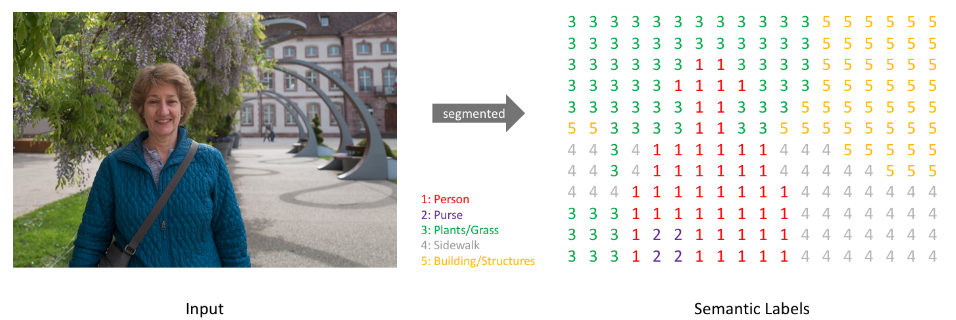

### Import Dependencies

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
import tensorflow
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-02-02 16:01:42.014718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 16:01:42.014856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 16:01:42.170428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__

'2.15.0'

In [3]:
np.random.seed(2024)
SIZE = 256      # set size for the images (heigth & width)

First of all, let's read the csv `classes` containing all the informations on the classes labels in the dataset, as well the rgb encoding of each colour, since each colour represent a class in the masks derived by segmenting the images. 

In [4]:
classes = pd.read_csv("/kaggle/input/camvid/CamVid/class_dict.csv", index_col =0)
classes.T

name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


### Functions

Now let's define a couple of functions that will be useful for loading data and plotting the images and masks couples.

In [53]:
def load_images(paths, size=SIZE, scale=None):
    img_list = []

    for image_path in paths:
        img = cv2.imread(image_path, scale)                                        # 0 to convert to grayscale (should ontain an array (n, h, w, 1) <=> (n, h, w))
        img = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)       # If you want to get the same order as in the color mapping of CAMVID, use the cv converted
        img = cv2.resize(img, (SIZE, SIZE))                                 # with default interpolation = bilinear
        img_list.append(img)
    
    return np.array(img_list)


def show_pairs(fig1, fig2, leftTitle, rightTitle):
    
    plt.subplot(1,2,1)
    plt.title(leftTitle)
    plt.imshow(fig1)
    
    plt.subplot(1,2,2)
    plt.title(rightTitle)
    plt.imshow(fig2)
    
    plt.show()
    plt.tight_layout()

def show_tris(fig1, fig2, fig3, leftTitle, centerTitle, rightTitle):
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(1,3,1)
    plt.title(leftTitle)
    plt.imshow(fig1)
    
    plt.subplot(1,3,2)
    plt.title(centerTitle)
    plt.imshow(fig2)
    
    plt.subplot(1,3,3)
    plt.title(rightTitle)
    plt.imshow(fig3)
    
    plt.show()
    plt.tight_layout()

### Data Loading

Now let's load the data using the function defined above `load_images()`; which takes as input the paths of the datasets (already split in train, validation and test.

In [6]:
for item in os.listdir('/kaggle/input/camvid/CamVid'):
    item_path = os.path.join('/kaggle/input/camvid/CamVid', item)
    print(item_path)

/kaggle/input/camvid/CamVid/class_dict.csv
/kaggle/input/camvid/CamVid/val_labels
/kaggle/input/camvid/CamVid/test_labels
/kaggle/input/camvid/CamVid/val
/kaggle/input/camvid/CamVid/train_labels
/kaggle/input/camvid/CamVid/test
/kaggle/input/camvid/CamVid/train


As we said before, `class_dict.csv` contains the reference of each class as well as their rgb encoding. 

The other elements are all folder containing the images and masks of each set: train, val and test.

Before loading the data we want to create many lists containing the path of each image-mask for each set; we also apply the sorted to all so that we can have sorted path and images and masks are in the same index position. 

In [7]:
root_path = '/kaggle/input/camvid/CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [8]:
# load TRAIN data
train_images = load_images(train_image_paths, scale=1)
train_masks = load_images(train_mask_paths, scale=1)

libpng warning: iCCP: known incorrect sRGB profile


In [9]:
# check the shapes

train_images.shape, train_masks.shape

((369, 256, 256, 3), (369, 256, 256, 3))

Both the images and masks have 3 channels (last axis) that refer to the rgb encoding. 

In [10]:
# load VAL data
val_images = load_images(val_image_paths, scale=1)
val_masks = load_images(val_mask_paths, scale=1)

In [11]:
val_images.shape, val_masks.shape

((100, 256, 256, 3), (100, 256, 256, 3))

In [12]:
# load TEST data (images and masks)
test_images = load_images(test_image_paths, scale=1)
test_masks = load_images(test_mask_paths, scale=1)

In [13]:
test_images.shape, test_masks.shape

((232, 256, 256, 3), (232, 256, 256, 3))

Now let's recall the `show_pairs()` function to display one image with its relative mask.

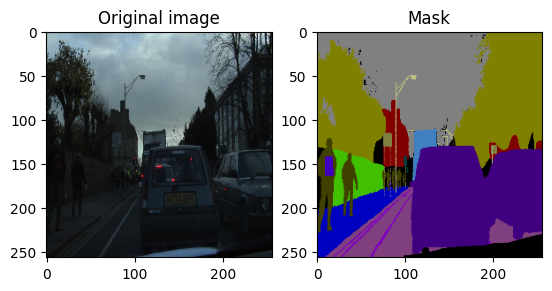

<Figure size 640x480 with 0 Axes>

In [14]:
show_pairs(train_images[1], train_masks[1], 'Original image', 'Mask')

## ENCODING


Before moving to the models, we need to encode the masks. 

As we can see from above, the masks are encoded in the same way as the images (Rgb) but have different colors where each one represent the membership to a class (to an object that is the target of the segmentation on the original image). 

Its common for segmentation tasks to convert the rgb encoding first to an integer class encoding, and then to a categorical encoding in the form of a one-hot encoding. By integer class encoding we mean that the rgb 3 channel encoding will be converted to a single channel encoding that encompasses all the classes by formatting each class as a integer number (as we can see from the image at the beginning).

Since in this case we have 32 classes, the integer class encoding will produce a single channel encode that will vary from 0 to 31; where each integer number refers to a class; e.g. 5 could be referred to the CAR class. 

However, after converting to class encoding, we will move to one hot encoding where the new arrays containing the masks will have the last axis with dimension of 32 channels. Basically, considering one pixel of an image, every of the 32 channels is binary and only 1 channel will have a value of 1 indicating that the pixel have a specific colour referred to a class. 

In [15]:
classes.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [16]:
# Create a class column to refer to the classes numerically

classes['Class'] = np.arange(0,  classes.shape[0])
classes.head()

,r,g,b,Class
name,,,,
Animal,64,128,64,0
Archway,192,0,128,1
Bicyclist,0,128,192,2
Bridge,0,128,64,3
Building,128,0,0,4


As we can see, each class now have an integer number in the column 'Class' referring to itself. 

Now we create two functions to encode the RGB mask into a multiclass 1 channel image; and one function that will convert the output of che neural networks into an rgb channels comparable with the original masks. 

In [17]:
def adj_masks(class_mapping, masks):

    # Create a lookup table (a dictionary as [r, g, b] : label_class) for all RGB values
    lookup_table = class_mapping.set_index(['r', 'g', 'b'])['Class'].to_dict()

    # Extract RGB channels from masks
    r_channel = masks[:, :, :, 0]
    g_channel = masks[:, :, :, 1]
    b_channel = masks[:, :, :, 2]

    # Map RGB values to class labels using the lookup table
    class_labels = np.vectorize(lambda r, g, b: lookup_table.get((r, g, b), 30))(r_channel, g_channel, b_channel)
    
    # In classes df the class 30 represent VOID, that represent pixels with colours not in the classes mapping
    # 30 is going be subistuted and represent the pixels not found in our rgb map 
    # from the dataframes classes (there is a spefific class call void)

    return class_labels.astype(np.uint8)
    
def back_to_rgb(class_mapping, masks):
    # Create a dictionary from the class mapping DataFrame for efficient lookup
    class_dict = class_mapping.set_index('Class')[['r', 'g', 'b']].to_dict(orient='index')

    # Convert masks to RGB-encoded masks using vectorized operations
    class_values = masks.flatten()
    rgb_encoded_masks = np.zeros((*masks.shape[:-1], 3), dtype=np.uint8)
    
    for class_val, rgb_values in class_dict.items():
        mask_indices = class_values == class_val
        rgb_encoded_masks[mask_indices.reshape(masks.shape[0], masks.shape[1], masks.shape[2]), :] = [rgb_values['r'], rgb_values['g'], rgb_values['b']]

    return rgb_encoded_masks

In simple terms:
- `adjust_mask(class_mapping, masks)` -> the adjusted mask will have shape (256, 256, 32) where 32 is the number of channels of the image each representing one of the classes; since we have 32 classes. `class_mapping` by default is the `classes` dataframe containing the reference of each class to its rgb encoding. As we can see from the plot above a column class have been created in this dataframe, and has singular values from 0 to 31 representing our 32 classes.

- `back_to_rgb(class_mapping, masks)` -> the masks will be the reverted into rgb turning the output shape of the network (256, 256, 32) into 256, 256, 32) . The converted mask back to rgb will be basically the same exact thing as the mask given in input to the adjust_mask function.

N.B. :
In classes df the class 30 represent `VOID`, that represent pixels with colours not in the classes mapping
In the function adj_masks() 30 is going be subistuted and represent the pixels not found in our rgb map 

In [18]:
## check if the ENCODE-DECODE from rgb to class and back to rgb from class is working:

prova = adj_masks(classes, train_masks[:10])
prova = np.expand_dims(prova, axis=3)
prova = back_to_rgb(classes, prova)

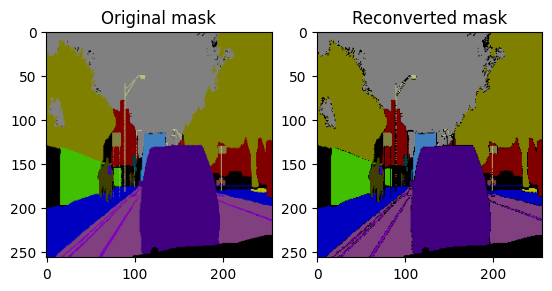

<Figure size 640x480 with 0 Axes>

In [19]:
show_pairs(train_masks[3], prova[3],'Original mask','Reconverted mask') 

# the adj_masks and back_to_rgb are properly working

### Start encoding the data

In [20]:
train_masks_encoded = adj_masks(classes, train_masks)

train_masks_encoded = np.expand_dims(train_masks_encoded, 3)
train_masks_encoded.shape

(369, 256, 256, 1)

The shape of last axis is of the desired dimension, a single channel. 

Now check the unique values:

In [21]:
np.unique(train_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31],
      dtype=uint8)

Comments: class 28 is missing for the train masks, this means that in the train sample there is no object part of that class.

In [22]:
val_masks_encoded = adj_masks(classes, val_masks)

val_masks_encoded = np.expand_dims(val_masks_encoded, 3)
val_masks_encoded.shape

(100, 256, 256, 1)

In [23]:
np.unique(val_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31], dtype=uint8)

Comments : class 25 and 28 missing. 

In [24]:
test_masks_encoded = adj_masks(classes, test_masks)

test_masks_encoded = np.expand_dims(test_masks_encoded, 3)
test_masks_encoded.shape

(232, 256, 256, 1)

In [25]:
np.unique(test_masks_encoded)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31], dtype=uint8)

Comments : class 25 and 28 missing. 

In [26]:
len(np.unique(train_masks_encoded)), len(np.unique(val_masks_encoded)), len(np.unique(test_masks_encoded))

(31, 30, 30)

As we seen above; one class is missing for the train set and two classes are missing in the test and val set.
This is confirmed also by the lengths of the unique values of each set printed above, we know that there are 32 classes according to the `classes.csv` but here a few are missing. 

This represent a problem, we need to remove this classes; update the class.csv by removing the unused classes and perform again the encoding. Additionally, we need to remove the observations of class 25 from the train_images and train_masks otherwise we are going to have problem since the val and test sets would enter the networks with a different dimension for the last axis (remember, we need to encode in one-hot-encoding that'll have dimension=n° of classes; so if the n° of classes in the sets are different the arrays referred to a set will have different dimension).

In [27]:
classes.tail(7)
# take rgb encoding of train class (25)

,r,g,b,Class
name,,,,
Train,192,64,128,25
Tree,128,128,0,26
Truck_Bus,192,128,192,27
Tunnel,64,0,64,28
VegetationMisc,192,192,0,29
Void,0,0,0,30
Wall,64,192,0,31


In [28]:
# save rgb encoding of class 25 to remove it

rgb_25 = np.array([192, 64, 128])
rgb_25

array([192,  64, 128])

In [29]:
# Create a function to remove observations within train_images and train_masks containing the class 25

def remove_class(masks, rgb, images):
    # Check for equality along the last axis to identify masks containing 
    # the rgb value of the desired class to remove
    contains_rgb = np.any(np.all(masks == rgb, axis=-1), axis=(1, 2))

    # Find the indices of masks (the observations, masks in the mask array)
    # containing the rgb value
    containing_indices = np.where(contains_rgb)[0]

    # Remove masks containing the rgb value (from both images and masks)
    # so that they can have the same axis=1 dimension
    return np.delete(masks, containing_indices, axis=0), np.delete(images, containing_indices, axis=0)

In [30]:
# Store the new masks and images with class 25 removed

train_masks, train_images = remove_class(train_masks, rgb_25, train_images)

In [31]:
train_masks.shape, train_images.shape

((368, 256, 256, 3), (368, 256, 256, 3))

We succesfully removed the observations from class 25.

Before `train_masks` and `train_images` had shape `(369, 256, 256, 3)` but now `(368, 256, 256, 3)` so only 1 observation is lost

Now we need to update the `class.csv` by removing the unused class and re-arrangin the `Class` column.

In [32]:
# these are the classes we have in ALL SETS (Train, test, val) -> we don't have 25 and 28 
classes_in = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31]

condition = classes['Class'].isin(classes_in)
classes = classes[condition]
classes

,r,g,b,Class
name,,,,
Animal,64,128,64,0
Archway,192,0,128,1
Bicyclist,0,128,192,2
Bridge,0,128,64,3
Building,128,0,0,4
Car,64,0,128,5
CartLuggagePram,64,0,192,6
Child,192,128,64,7
Column_Pole,192,192,128,8


In [33]:
# Now re arrange class column

classes['Class'] = np.arange(0,  classes.shape[0])
classes.tail()

,r,g,b,Class
name,,,,
Tree,128,128,0,25
Truck_Bus,192,128,192,26
VegetationMisc,192,192,0,27
Void,0,0,0,28
Wall,64,192,0,29


As we can see now the total number of classes is 30 (from 0 to 29).

We need to update the adk_masks function since the new Void class have an integer referencing to its rgb channel equal to 28.

In [34]:
# Update adj mask function (now void class is 28)

def adj_masks(class_mapping, masks):

    lookup_table = class_mapping.set_index(['r', 'g', 'b'])['Class'].to_dict()

    r_channel = masks[:, :, :, 0]
    g_channel = masks[:, :, :, 1]
    b_channel = masks[:, :, :, 2]

    class_labels = np.vectorize(lambda r, g, b: lookup_table.get((r, g, b), 28))(r_channel, g_channel, b_channel)
    
    return class_labels.astype(np.uint8)

In [35]:
# Redo the encoding on the masks
train_masks_encoded = adj_masks(classes, train_masks)
train_masks_encoded = np.expand_dims(train_masks_encoded, 3)

test_masks_encoded = adj_masks(classes, test_masks)
test_masks_encoded = np.expand_dims(test_masks_encoded, 3)

val_masks_encoded = adj_masks(classes, val_masks)
val_masks_encoded = np.expand_dims(val_masks_encoded, 3)


In [36]:
np.unique(train_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=uint8)

In [37]:
len(np.unique(train_masks_encoded)), len(np.unique(val_masks_encoded)), len(np.unique(test_masks_encoded))

(30, 30, 30)

Now As we can see from the print above now the three masks sets have the same number of classes.

Let's check again the new shapes:

In [38]:
train_masks_encoded.shape, val_masks_encoded.shape, test_masks_encoded.shape, 

((368, 256, 256, 1), (100, 256, 256, 1), (232, 256, 256, 1))

### One hot encode 

Now we need to perform one hot encoding in order to feed the data to the networks. We'll simply use the keras function `to_categorical()`

In [39]:
from tensorflow.keras.utils import to_categorical

train_masks_encoded = to_categorical(train_masks_encoded, num_classes=30) 
val_masks_encoded = to_categorical(val_masks_encoded, num_classes=30)
test_masks_encoded = to_categorical(test_masks_encoded, num_classes=30) 


In [40]:
train_masks_encoded.shape, val_masks_encoded.shape, test_masks_encoded.shape

((368, 256, 256, 30), (100, 256, 256, 30), (232, 256, 256, 30))

As we can see the masks are of the desired shape, last channels' dimension is 30; so a vector of 30 binary values to express the membership to one class (one colour in rgb format)

In [41]:
train_masks_encoded[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

### Preprocessing for modeling

Without touching the masks, we perform normalization and not the dividision of every pixel by 255, obtaining pixel values between 0 and 1 in float32 format.
$$X_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}$$

In [42]:
# store images copy before normalizing (for later use to plot)

train_images_copy = train_images 
val_images_copy = val_images 
test_images_copy = test_images 

In [43]:
train_images = normalize(train_images, axis=1)

In [44]:
val_images = normalize(val_images, axis=1)
test_images = normalize(test_images, axis=1)

In [44]:
train_images.shape, train_masks_encoded.shape

((368, 256, 256, 3), (368, 256, 256, 30))

- INPUT IMAGE is an RGB image
- OUTPUT IMAGE is a 30 channel image (one hot encoded) that we will revert to rgb after the prediction to compare it with the ground truth mask

### Training issues

Since we are dealing with a multiclass problem, there is a high chance that, as we can see from the images and masks, there is class imbalance in terms of weights meaning that there are some classes (like the road or the walls) that have much more in-sample observations with pixels associated to them, implying that other minority classes (such as people, animals, trees..) have less training examples. By pixels we mean 1s in the OHE mask tensor. We will address this problem by using a loss function that accounts for class imbalance, the FOCAL LOSS!

#### Focal loss

Focal Loss in multiclass classification formula: (someone also uses some hybrid loss by performing a linear combination of 2 losses)
$$Focal Loss = -\alpha*((1-p)^\gamma)*log(p)$$
Parameters:
- $\alpha$ -> the same as wighting factor in balanced cross entropy
- $\gamma$ -> focusing parameter for modulating factor (1-p)

Default value:
- $\gamma = 2.0$ as mentioned in the paper
- $\alpha = 0.25$ as mentioned in the paper

paper: https://arxiv.org/pdf/1708.02002.pdf

tf: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy

'

# Define the models

#### Training procedure

Speaking about the training procedure, we could think that a Unet-like architecture should need many training examples. However Unet was conceived for biomedical images and complex structures working extremly well also with few examples.

In [45]:
# General
import tensorflow as tf
from tensorflow.keras import backend as K

# Network Architecture
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam

# Metrics
from keras.metrics import MeanIoU

In [46]:
# model shapes

IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

shapes = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

## Simple-Unet

![alternatvie text](https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [95]:
############################################################################################################################################################################

# BLOCKS
def contraction_block(input_tensor, num_filters, doBatchNorm = True, drop_rate = None):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)             # to make computations more efficient
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    pooled = MaxPooling2D((2, 2))(x)            # OG paper proposed strides=2 but we leave them default to pool_size = 2
    pooled = Dropout(drop_rate)(pooled)
    return x, pooled



def expansive_block(copy, input_tensor, num_filters, doBatchNorm = True, drop_rate = None):  
    # Conv2dtranspose =! upsampling (both the concept and the keras layer). both increase dim of arrays.
    # upsampling2d is the opposite of pooling repeating rows and columns of input.
    # Conv2dtranspose performs upsampling and then convolution. 
    x = Conv2DTranspose(num_filters, kernel_size = (3, 3), strides = (2, 2), padding='same')(input_tensor)       

    # Concatenation: crop the copy from the specular contraction block and concatenate it to the
    # current respective decoder layer of the expansive path
    x = concatenate([x, copy])

    # add simple 2D convolutions
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# will be useful also for autoencoder
def convolution_block(input_tensor, num_filters, drop_rate = None, doBatchNorm = True):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# UNET
def Unet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    copy1, p1 = contraction_block(input_tensor=input_layer, num_filters = filters*1, drop_rate=0.1, doBatchNorm=True)
    copy2, p2 = contraction_block(input_tensor=p1, num_filters = filters*2, drop_rate=0.1, doBatchNorm=True)
    copy3, p3 = contraction_block(input_tensor=p2, num_filters = filters*4, drop_rate=0.2, doBatchNorm=True)
    copy4, p4 = contraction_block(input_tensor=p3, num_filters = filters*8, drop_rate=0.2, doBatchNorm=True)

    x5 = convolution_block(input_tensor=p4, num_filters=filters*16, drop_rate = 0.2, doBatchNorm=True)

    p6 = expansive_block(copy=copy4, input_tensor=x5, num_filters = filters*8, drop_rate = 0.2, doBatchNorm=True)
    p7 = expansive_block(copy=copy3, input_tensor=p6, num_filters = filters*4, drop_rate = 0.2, doBatchNorm=True)
    p8 = expansive_block(copy=copy2, input_tensor=p7, num_filters = filters*2, drop_rate = 0.1, doBatchNorm=True)
    p9 = expansive_block(copy=copy1, input_tensor=p8, num_filters = filters*1, drop_rate = 0.1, doBatchNorm=True)

    # num_classes should be 3 if working with OG images and masks
    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(p9)
    model = Model(inputs=[input_layer], outputs=[output], name='Unet')
    return model

In [96]:
model = Unet(input_size=shapes, filters = 16, n_classes = 30, activation='softmax')
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_168 (Conv2D)         (None, 256, 256, 16)         448       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_162 (B  (None, 256, 256, 16)         64        ['conv2d_168[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_108 (Activation  (None, 256, 256, 16)         0         ['batch_normalization_162[0

In [98]:
history = model.fit(train_images, train_masks_encoded,                                # train_images, train_masks_encoded,  
                    verbose=1,
                    batch_size = 16,
                    validation_data = (val_images, val_masks_encoded),
                    epochs=150)

Epoch 1/150


2024-02-02 11:59:19.431207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 19s 312ms/step - loss: 2.7717 - accuracy: 0.3364 - val_loss: 3.4647 - val_accuracy: 0.4084
Epoch 2/150
23/23 [==============================] - 5s 209ms/step - loss: 2.1974 - accuracy: 0.5486 - val_loss: 17.6765 - val_accuracy: 0.0987
Epoch 3/150
23/23 [==============================] - 5s 209ms/step - loss: 1.8582 - accuracy: 0.6835 - val_loss: 3.3921 - val_accuracy: 0.2216
Epoch 4/150
23/23 [==============================] - 5s 211ms/step - loss: 1.5917 - accuracy: 0.7361 - val_loss: 3.0306 - val_accuracy: 0.4195
Epoch 5/150
23/23 [==============================] - 5s 205ms/step - loss: 1.4074 - accuracy: 0.7460 - val_loss: 2.6773 - val_accuracy: 0.2848
Epoch 6/150
23/23 [==============================] - 5s 212ms/step - loss: 1.2763 - accuracy: 0.7522 - val_loss: 2.6020 - val_accuracy: 0.3143
Epoch 7/150
23/23 [==============================] - 5s 212ms/step - loss: 1.1624 - accuracy: 0.7610 - val_loss: 2.3651 - val_accuracy: 0.4279
Epoch 8/1

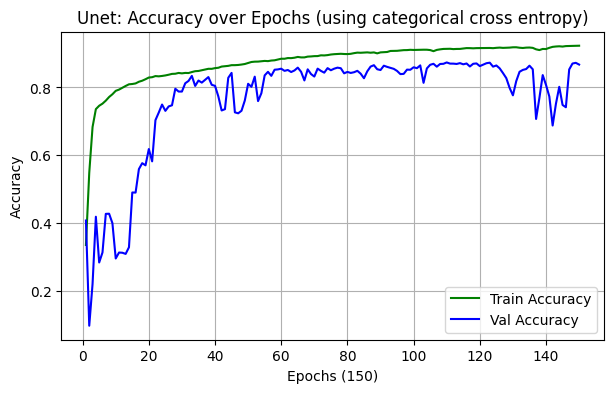

In [102]:
train_acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history, label='Val Accuracy', color='blue')


plt.title('Unet: Accuracy over Epochs (using categorical cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

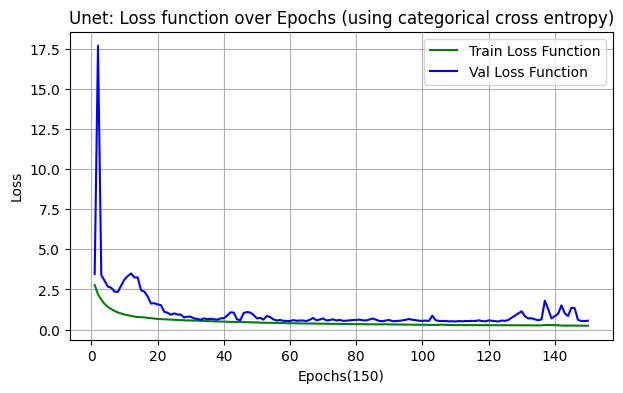

In [101]:
train_loss_history = history.history['loss']
val_loss_history = history.history['val_loss']


plt.figure(figsize=(7, 4))

plt.plot(epochs, train_loss_history, label='Train Loss Function', color='green')
plt.plot(epochs, val_loss_history, label='Val Loss Function', color='blue')


plt.title('Unet: Loss function over Epochs (using categorical cross entropy)')
plt.xlabel('Epochs(150)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

In [103]:
# PREDICT AND CONVERT BACK TO RGB

y_pred=model.predict(test_images)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_pred_argmax = np.expand_dims(y_pred_argmax, axis=3)

8/8 [==============================] - 1s 63ms/step


In [104]:
y_pred_rgb = back_to_rgb(classes, y_pred_argmax)

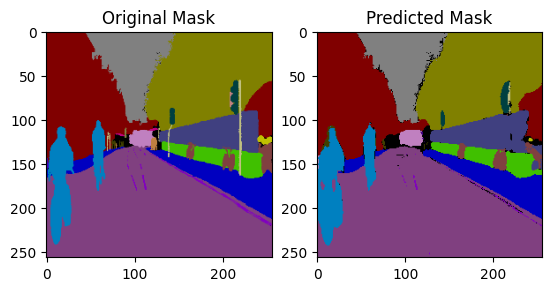

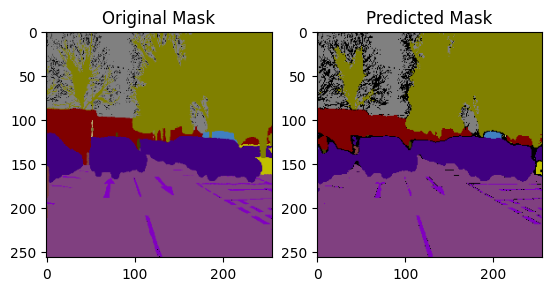

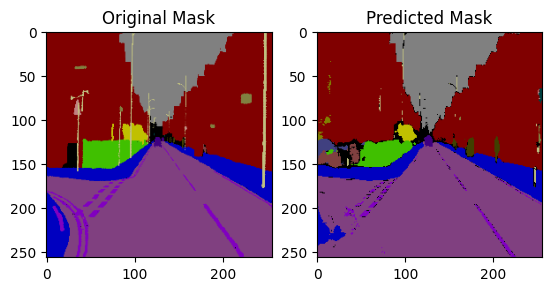

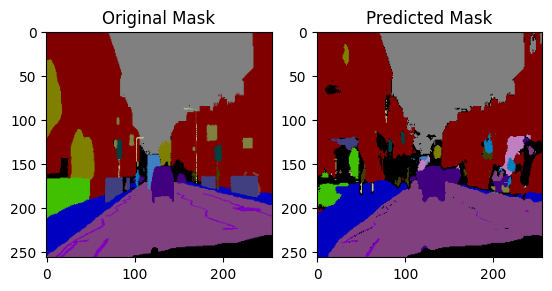

<Figure size 640x480 with 0 Axes>

In [111]:
# UNET, 150 epochs, categorical_crossentropy, softmax

rand = np.random.randint(1, y_pred_argmax.shape[0], 5)

for i in rand[1:]:
    show_pairs(test_masks[i], y_pred_rgb[i], 'Original Mask', 'Predicted Mask'), 


In [112]:
# save the Unet model

model.save('Unet_150_catCE.keras')

## Residual Unet with categorical focal cross_entropy

![alternatvie text](https://www.researchgate.net/publication/327748708/figure/fig2/AS:698665882619906@1543586335266/Illustration-of-the-proposed-Res-Unet-architecture-as-the-generator.png)



In [72]:
# Residual block: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf (fig 4)
# there are 2 variants (2. is the one proposed in OG paper of ResNet)
# 1. conv - BN - Activation - conv - BN - Activation - shortcut  - BN - shortcut+BN
# 2. conv - BN - Activation - conv - BN - shortcut  - BN - addition() - Activation

def residual_contraction_block(input_tensor, num_filters, doBatchNorm = True): 
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)       # default kernel initializer to "glorot_uniform"
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    # x = Activation('relu')(x)    #Activation before addition with residual

    # 1x1 convolution on input image
    residual = Conv2D(num_filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(input_tensor)
    if doBatchNorm:
        residual = BatchNormalization()(residual)
    
    # sum convolution block with residual and perform 2x2 max pooling
    res_x = Add()([residual, x])
    res_x = Activation('relu')(res_x)       # act f in the end like the OG paper proposes
    # pooled = MaxPooling2D((2, 2))(res_x)
    # pooled = Dropout(drop_rate)(pooled)
    # return pooled
    return res_x


def ResUnet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    # downsample
    x1 = residual_contraction_block(input_tensor=input_layer, num_filters = filters*1, doBatchNorm = True)    
    p1 = MaxPooling2D((2, 2))(x1)
    p1 = Dropout(rate=0.1)(p1)

    x2 = residual_contraction_block(input_tensor=p1, num_filters = filters*2, doBatchNorm = True)    
    p2 = MaxPooling2D((2, 2))(x2)
    p2 = Dropout(rate=0.1)(p2)

    x3 = residual_contraction_block(input_tensor=p2, num_filters = filters*4, doBatchNorm = True)    
    p3 = MaxPooling2D((2, 2))(x3)
    p3 = Dropout(rate=0.2)(p3)

    x4 = residual_contraction_block(input_tensor=p3, num_filters = filters*8, doBatchNorm = True)    
    p4 = MaxPooling2D((2, 2))(x4)
    p4 = Dropout(rate=0.2)(p4)

    # intermediate
    x5 = residual_contraction_block(input_tensor=p4, num_filters = filters*16, doBatchNorm = True)
    x5 = Dropout(rate=0.2)(x5)

    # upsample
    x6 = Conv2DTranspose(filters = filters*8, kernel_size = (3, 3), strides = (2, 2), padding='same')(x5)
    x7 = concatenate([x6, x4])
    x8 = residual_contraction_block(input_tensor=x7, num_filters = filters*8, doBatchNorm = True)
    x8 = Dropout(rate=0.2)(x8)

    x9 = Conv2DTranspose(filters = filters*4, kernel_size = (3, 3), strides = (2, 2), padding='same')(x8)
    x10 = concatenate([x9, x3])
    x11 = residual_contraction_block(input_tensor=x10, num_filters = filters*4, doBatchNorm = True)
    x11 = Dropout(rate=0.2)(x11)

    x12 = Conv2DTranspose(filters = filters*2, kernel_size = (3, 3), strides = (2, 2), padding='same')(x11)
    x13 = concatenate([x12, x2])
    x14 = residual_contraction_block(input_tensor=x13, num_filters = filters*2, doBatchNorm = True)
    x14 = Dropout(rate=0.1)(x14)

    x15 = Conv2DTranspose(filters = filters*1, kernel_size = (3, 3), strides = (2, 2), padding='same')(x14)
    x16 = concatenate([x15, x1])
    x17 = residual_contraction_block(input_tensor=x16, num_filters = filters*1, doBatchNorm = True)
    x17 = Dropout(rate=0.1)(x17)

    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(x17)
    model = Model(inputs=[input_layer], outputs=[output], name='ResUnet')
    return model

In [73]:
res_Unet = ResUnet(input_size=shapes, filters = 16, n_classes = 30, activation='softmax')

res_Unet.compile(optimizer='Adam',
                loss='categorical_focal_crossentropy',
                metrics=['accuracy']
                )

In [74]:
res_Unet.summary()

Model: "ResUnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_140 (Conv2D)         (None, 256, 256, 16)         448       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_135 (B  (None, 256, 256, 16)         64        ['conv2d_140[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_90 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_13

In [75]:
history_res = res_Unet.fit(train_images, train_masks_encoded,                               
                    verbose=1,
                    batch_size = 16,
                    validation_data = (test_images, test_masks_encoded),
                    epochs=150)

Epoch 1/150


2024-02-02 11:19:34.372883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResUnet/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 32s 651ms/step - loss: 0.7185 - accuracy: 0.1806 - val_loss: 0.8960 - val_accuracy: 0.1058
Epoch 2/150
23/23 [==============================] - 7s 329ms/step - loss: 0.5178 - accuracy: 0.4436 - val_loss: 2.9447 - val_accuracy: 0.1662
Epoch 3/150
23/23 [==============================] - 7s 325ms/step - loss: 0.3824 - accuracy: 0.6244 - val_loss: 2.7922 - val_accuracy: 0.1809
Epoch 4/150
23/23 [==============================] - 7s 328ms/step - loss: 0.3063 - accuracy: 0.6850 - val_loss: 0.7229 - val_accuracy: 0.3141
Epoch 5/150
23/23 [==============================] - 7s 323ms/step - loss: 0.2588 - accuracy: 0.7156 - val_loss: 0.6821 - val_accuracy: 0.2827
Epoch 6/150
23/23 [==============================] - 7s 328ms/step - loss: 0.2251 - accuracy: 0.7351 - val_loss: 0.6334 - val_accuracy: 0.2887
Epoch 7/150
23/23 [==============================] - 7s 326ms/step - loss: 0.2034 - accuracy: 0.7488 - val_loss: 0.6807 - val_accuracy: 0.2948
Epoch 8/15

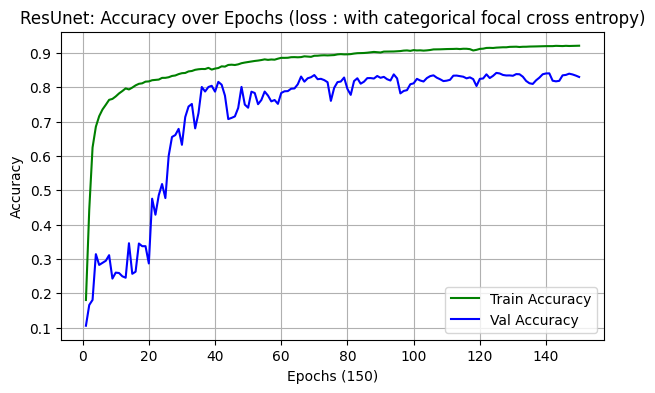

In [113]:
train_acc_history_res = history_res.history['accuracy']
val_acc_history_res = history_res.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history_res)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history_res, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history_res, label='Val Accuracy', color='blue')


plt.title('ResUnet: Accuracy over Epochs (loss : with categorical focal cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

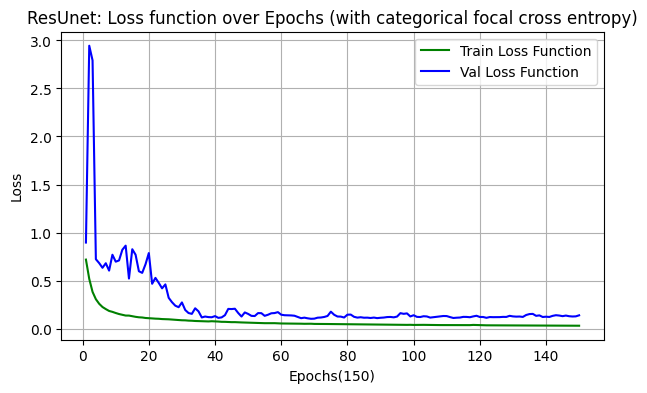

In [114]:
train_loss_history_res = history_res.history['loss']
val_loss_history_res = history_res.history['val_loss']


plt.figure(figsize=(7, 4))

plt.plot(epochs, train_loss_history_res, label='Train Loss Function', color='green')
plt.plot(epochs, val_loss_history_res, label='Val Loss Function', color='blue')


plt.title('ResUnet: Loss function over Epochs (with categorical focal cross entropy)')
plt.xlabel('Epochs(150)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

In [48]:
# PREDICT AND CONVERT BACK TO RGB

y_pred_Res= res_Unet.predict(val_images)
y_pred_argmax_Res=np.argmax(y_pred_Res, axis=3)
y_pred_argmax_Res = np.expand_dims(y_pred_argmax_Res, axis=3)

4/4 [==============================] - 7s 431ms/step


In [49]:
y_pred_rgb_Res = back_to_rgb(classes, y_pred_argmax_Res)

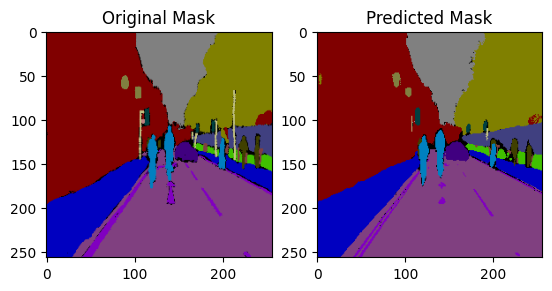

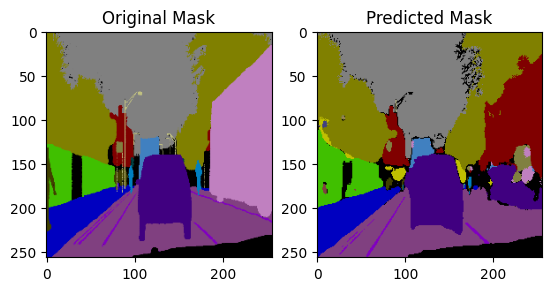

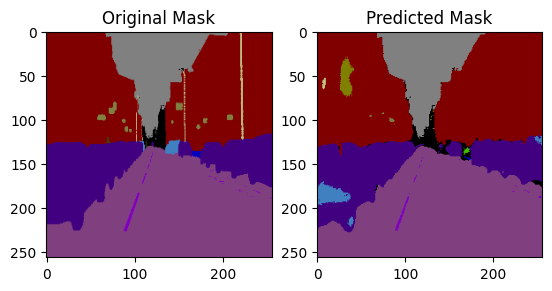

<Figure size 640x480 with 0 Axes>

In [68]:
# ResUnet, 150 epochs, categorical_focal_crossentropy, softmax

rand = np.random.randint(1, y_pred_argmax_Res.shape[0], 3)

for i in rand:
    show_pairs(val_masks[i], y_pred_rgb_Res[i], 'Original Mask', 'Predicted Mask'), 


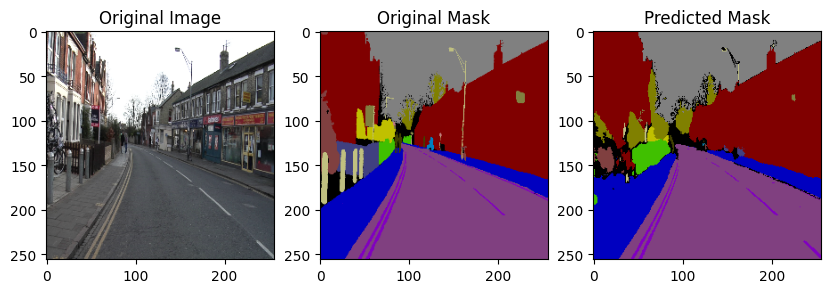

<Figure size 640x480 with 0 Axes>

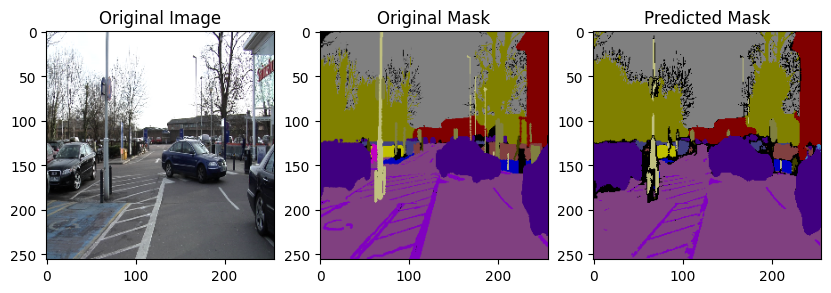

<Figure size 640x480 with 0 Axes>

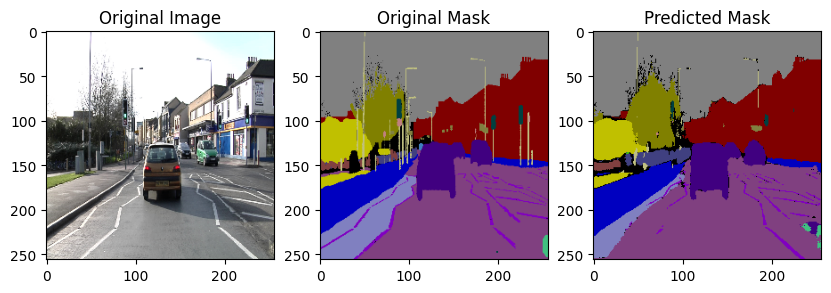

<Figure size 640x480 with 0 Axes>

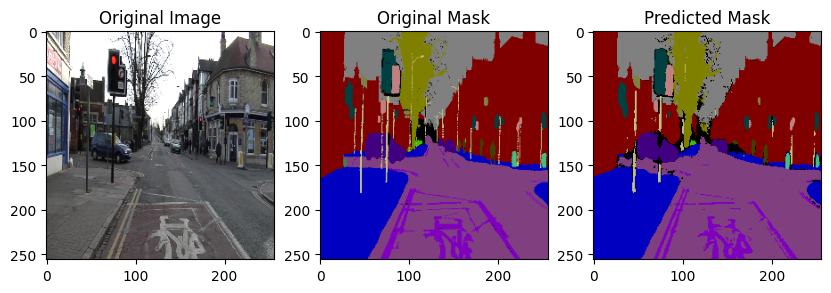

<Figure size 640x480 with 0 Axes>

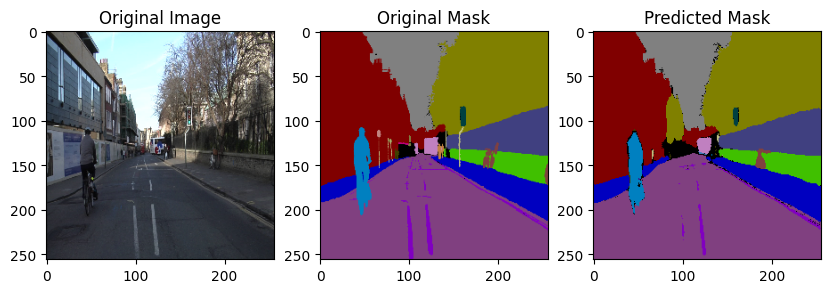

<Figure size 640x480 with 0 Axes>

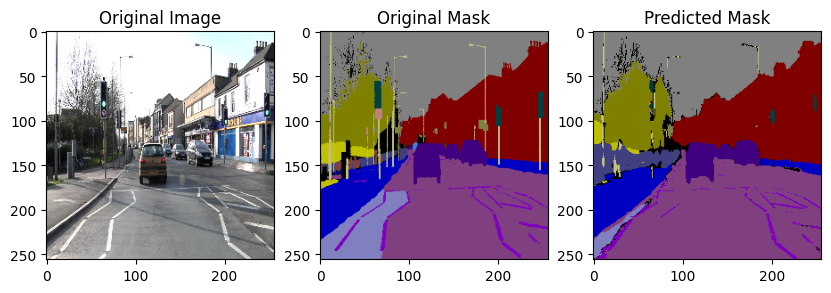

<Figure size 640x480 with 0 Axes>

In [61]:
# 150 epochs, categorical_focal_crossentropy, softmax

rand = np.random.randint(1, y_pred_argmax_Res.shape[0], 6)

for i in rand:
    show_tris(val_images_copy[i], val_masks[i], y_pred_rgb_Res[i], 'Original Image', 'Original Mask', 'Predicted Mask'), 

In [85]:
# save the res_Unet model

res_Unet.save('resUnet_150_focalCE.keras')

## Model Evaluation

In [47]:
from tensorflow.keras.models import load_model

res_Unet = load_model('/kaggle/input/resunet_150_focalce/keras/boh/1/resUnet_150_focalCE.keras')

In [128]:
res_Unet.evaluate(val_images, val_masks_encoded)

4/4 [==============================] - 1s 113ms/step - loss: 0.0895 - accuracy: 0.8684


[0.08953393250703812, 0.8683671355247498]

Let's evaluate the loss and the accuracy on the other sets (here is the val set since we switched them due to the larger size of the test set) 

In [51]:
pd.DataFrame([res_Unet.evaluate(train_images, train_masks_encoded),
              res_Unet.evaluate(test_images, test_masks_encoded),
              res_Unet.evaluate(val_images, val_masks_encoded)], 
             columns=['Loss', 'Accuracy'],
             index = ['Train', 'Test','Val'])


4/4 [==============================] - 2s 465ms/step - loss: 0.0895 - accuracy: 0.8684


,Loss,Accuracy
Train,0.027418,0.924424
Test,0.138663,0.829723
Val,0.089534,0.868367


In [ ]:
As we can see our model is generalizing pretty well, there is no significant

#### Mean IoU

In [52]:
# Store the predictions in binary format (one hot encoding)

val_pred_binary = res_Unet.predict(val_images)

4/4 [==============================] - 1s 70ms/step


In [53]:
mIoU = tensorflow.keras.metrics.MeanIoU(num_classes=30)

mIoU.update_state(val_pred_binary, val_masks_encoded)
mIoU_val = mIoU.result().numpy()

0.35955057